# Consideraciones acerca de Threading

Tiempos de procesamiento de datos

    •	CPU L1 Cache: 0.9 ns
    •	RAM: 51 ns
    •	SSD: 0.08 a 0.15 ms = 80.000 a 150.000 ns 
    •	HDD 7.2k: 4 ms = 4.000.000 ns
    •	Red: 400 ms = 400.000.000 ns

Unidad equivalente 0.9 nanosegunos computacionales = 1 segundo humano

    •	CPU: 1 seg
    •	RAM: 1 minuto
    •	SSD: 1 a 2 dias
    •	HDD: 1mes y medio
    •	Red: 14 años

# Importamos las librerías

In [2]:
import pandas as pd
import requests
import numpy as np
import threading
import tqdm, sys
import pickle
import time, datetime as dt

# Config de display
pd.options.display.max_columns=6

# Claves de APIs
from _keys import *

## Tema Claves

Registrarse en (Todo gratarola)

* IEX: https://iexcloud.io/
* TDA-Ameritrade: https://developer.tdameritrade.com/apis 
    * Ir a MyApps >> Nueva App >> En callBack url poner cualquier url tipo http://google.com >> Listo, Ver consumer Key
* FMP: https://fmpcloud.io/
* Alpaca: https://alpaca.markets/
    * En Alpaca te dan un par: ApiKey y ApiSecret


Yo las guardé en un archivo _keys.py  que obviamente en el repo esta sin las claves,y lo tienen que actualizar


# Tickers del SP500

## Scrapping Basico

In [3]:
sp500_wiki = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500_wiki = sp500_wiki.loc[~sp500_wiki.Symbol.isin(['BRK.B' ,'BF.B'])]
sp500_wiki

,Symbol,Security,SEC filings,...,Date first added,CIK,Founded
0,MMM,3M Company,reports,...,1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,...,1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,...,2012-12-31,1551152,2013 (1888)
3,ABMD,ABIOMED Inc,reports,...,2018-05-31,815094,1981
4,ACN,Accenture plc,reports,...,2011-07-06,1467373,1989
...,...,...,...,...,...,...,...
500,YUM,Yum! Brands Inc,reports,...,1997-10-06,1041061,1997
501,ZBRA,Zebra Technologies,reports,...,2019-12-23,877212,1969
502,ZBH,Zimmer Biomet,reports,...,2001-08-07,1136869,1927
503,ZION,Zions Bancorp,reports,...,2001-06-22,109380,1873


In [6]:
sp500_tickers = sp500_wiki.Symbol.tolist()
sp500_tickers[:10]

['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES']

## Guardamos la data

In [4]:
with open('data/inicial/wiki_sp500.dat', 'wb') as file:
    pickle.dump(sp500_wiki, file)

In [5]:
with open('data/inicial/wiki_sp500.dat', 'rb') as file:
    loaded = pickle.load(file)
    
loaded

,Symbol,Security,SEC filings,...,Date first added,CIK,Founded
0,MMM,3M Company,reports,...,1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,...,1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,...,2012-12-31,1551152,2013 (1888)
3,ABMD,ABIOMED Inc,reports,...,2018-05-31,815094,1981
4,ACN,Accenture plc,reports,...,2011-07-06,1467373,1989
...,...,...,...,...,...,...,...
500,YUM,Yum! Brands Inc,reports,...,1997-10-06,1041061,1997
501,ZBRA,Zebra Technologies,reports,...,2019-12-23,877212,1969
502,ZBH,Zimmer Biomet,reports,...,2001-08-07,1136869,1927
503,ZION,Zions Bancorp,reports,...,2001-06-22,109380,1873


# Opciones desde TDA

In [7]:
c_key = TDA_KEY

In [ ]:
#pd.read_html(url)

In [9]:
def options(symbol):
    params = {'apikey' : c_key, 'symbol':symbol}
    endpoint = 'https://api.tdameritrade.com/v1/marketdata/chains'
    r = requests.get(url=endpoint ,params=params)
    return r.json()

In [10]:
ticker = 'GGAL'
chain = options(ticker)
chain

{'symbol': 'GGAL',
 'status': 'SUCCESS',
 'underlying': None,
 'strategy': 'SINGLE',
 'interval': 0.0,
 'isDelayed': True,
 'isIndex': False,
 'interestRate': 0.1,
 'underlyingPrice': 8.815000000000001,
 'volatility': 29.0,
 'daysToExpiration': 0.0,
 'numberOfContracts': 102,
 'putExpDateMap': {'2020-12-18:24': {'2.5': [{'putCall': 'PUT',
     'symbol': 'GGAL_121820P2.5',
     'description': 'GGAL Dec 18 2020 2.5 Put',
     'exchangeName': 'OPR',
     'bid': 0.0,
     'ask': 0.05,
     'last': 0.0,
     'mark': 0.03,
     'bidSize': 0,
     'askSize': 100,
     'bidAskSize': '0X100',
     'lastSize': 0,
     'highPrice': 0.0,
     'lowPrice': 0.0,
     'openPrice': 0.0,
     'closePrice': 0.0,
     'totalVolume': 0,
     'tradeDate': None,
     'tradeTimeInLong': 0,
     'quoteTimeInLong': 1606250990376,
     'netChange': 0.0,
     'volatility': 130.482,
     'delta': 0.0,
     'gamma': 0.0,
     'theta': 0.0,
     'vega': 0.0,
     'rho': 0.0,
     'openInterest': 0,
     'timeValue':

## Metemos el OptionChain en un DataFrame

In [13]:
ticker = 'AAPL'
chain = options(ticker)

v_calls = list(chain['callExpDateMap'].values())
v_calls_fechas = list(chain['callExpDateMap'].keys())
v_puts = list(chain['putExpDateMap'].values())
v_puts_fechas = list(chain['putExpDateMap'].keys())
calls = []
for i in range(len(v_calls)):
    v = list(v_calls[i].values())    
    for j in range(len(v)):
        calls.append(v[j][0])

puts = []
for i in range(len(v_puts)):
    v = list(v_puts[i].values())    
    for j in range(len(v)):
        puts.append(v[j][0])
        
contracts = pd.concat([pd.DataFrame(calls),pd.DataFrame(puts)])

tabla = contracts.loc[contracts.daysToExpiration>0]
tabla = tabla.loc[:,['symbol','strikePrice','daysToExpiration','putCall','bid','ask',
                     'last','volatility','openInterest','theoreticalOptionValue',
                     'delta', 'gamma', 'theta', 'vega', 'rho', 'inTheMoney']]

tabla.columns = ['symbol_opc','Strike','TTM','Type','Bid','Ask','Last','IV','OpenInt','Theor',
                 'delta', 'gamma', 'theta', 'vega', 'rho','ITM']

tabla['symbol'] = ticker

pd.options.display.max_columns = 20
tabla


,symbol_opc,Strike,TTM,Type,Bid,Ask,Last,IV,OpenInt,Theor,delta,gamma,theta,vega,rho,ITM,symbol
0,AAPL_112720C55,55.0,3,CALL,59.85,60.40,60.55,160.601,228,58.896,1,0,-0.01,0.000,0.007,True,AAPL
1,AAPL_112720C60,60.0,3,CALL,54.85,55.40,58.05,142.044,287,53.896,1,0,-0.01,0.000,0.008,True,AAPL
2,AAPL_112720C65,65.0,3,CALL,49.85,50.40,53.95,124.891,325,48.896,1,0,-0.01,0.000,0.008,True,AAPL
3,AAPL_112720C70,70.0,3,CALL,44.85,45.35,49.10,109.038,394,43.897,1,0,-0.01,0.000,0.009,True,AAPL
4,AAPL_112720C75,75.0,3,CALL,40.00,40.40,37.80,94.176,358,38.897,1,0,-0.01,0.000,0.01,True,AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058,AAPL_012023P190,190.0,787,PUT,79.30,80.95,80.30,34.646,1,81.567,-0.773,0.005,-0.01,0.509,-3.662,True,AAPL
1059,AAPL_012023P195,195.0,787,PUT,83.80,85.50,85.35,34.797,1,86.126,-0.787,0.005,-0.01,0.491,-3.793,True,AAPL
1060,AAPL_012023P200,200.0,787,PUT,88.35,90.10,90.07,34.869,11,90.686,-0.8,0.005,-0.01,0.473,-3.925,True,AAPL
1061,AAPL_012023P210,210.0,787,PUT,97.60,99.45,99.37,35.243,12,100.012,-0.822,0.004,-0.009,0.441,-4.18,True,AAPL


## Encapsulamos el DF en una función

In [14]:
def optionsDF(chain):
    try:
        v_calls = list(chain['callExpDateMap'].values())
        v_calls_fechas = list(chain['callExpDateMap'].keys())
        v_puts = list(chain['putExpDateMap'].values())
        v_puts_fechas = list(chain['putExpDateMap'].keys())
        calls = []
        for i in range(len(v_calls)):
            v = list(v_calls[i].values())    
            for j in range(len(v)):
                calls.append(v[j][0])

        puts = []
        for i in range(len(v_puts)):
            v = list(v_puts[i].values())    
            for j in range(len(v)):
                puts.append(v[j][0])

        contracts = pd.concat([pd.DataFrame(calls),pd.DataFrame(puts)])
        tabla = contracts.loc[contracts.daysToExpiration>0]
        tabla = tabla.loc[:,['symbol','strikePrice','daysToExpiration','putCall','bid','ask',
                             'last','volatility','openInterest','theoreticalOptionValue',
                             'delta', 'gamma', 'theta', 'vega', 'rho', 'inTheMoney']]

        tabla.columns = ['symbol_opc','Strike','TTM','Type','Bid','Ask','Last','IV','OpenInt','Theor',
                         'delta', 'gamma', 'theta', 'vega', 'rho','ITM']

        tabla['symbol'] = chain['symbol']
    except:
        tabla = pd.DataFrame()
        
    return tabla

In [15]:
ticker = 'FB'
df = optionsDF(options(ticker))
df

,symbol_opc,Strike,TTM,Type,Bid,Ask,Last,IV,OpenInt,Theor,delta,gamma,theta,vega,rho,ITM,symbol
0,FB_112720C135,135.0,3,CALL,141.70,142.35,138.95,145.409,6,133.430,1.000,0.000,0.000,0.000,0.000,True,FB
1,FB_112720C140,140.0,3,CALL,136.70,137.35,150.30,137.900,6,128.430,1.000,0.000,0.000,0.000,0.000,True,FB
2,FB_112720C145,145.0,3,CALL,131.70,132.35,126.36,130.696,3,123.430,1.000,0.000,0.000,0.000,0.000,True,FB
3,FB_112720C150,150.0,3,CALL,126.35,127.35,125.70,123.714,3,118.430,1.000,0.000,0.000,0.000,0.000,True,FB
4,FB_112720C155,155.0,3,CALL,121.35,122.35,130.75,117.016,5,113.430,1.000,0.000,0.000,0.000,0.000,True,FB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,FB_012023P480,480.0,787,PUT,207.00,211.80,210.49,32.589,6,215.980,-0.839,0.002,-0.015,1.035,-9.527,True,FB
1121,FB_012023P500,500.0,787,PUT,225.55,230.50,226.47,32.685,15,234.576,-0.859,0.002,-0.014,0.956,-10.047,True,FB
1122,FB_012023P520,520.0,787,PUT,244.00,248.95,0.00,32.550,0,253.173,-0.880,0.002,-0.012,0.871,-10.567,True,FB
1123,FB_012023P540,540.0,787,PUT,263.05,267.95,264.95,32.182,5,271.791,-0.900,0.002,-0.009,0.778,-11.087,True,FB


## Graficamos algo

In [16]:
from scipy import interpolate
import matplotlib.pyplot as plt

In [ ]:
Z  = f(x,y)

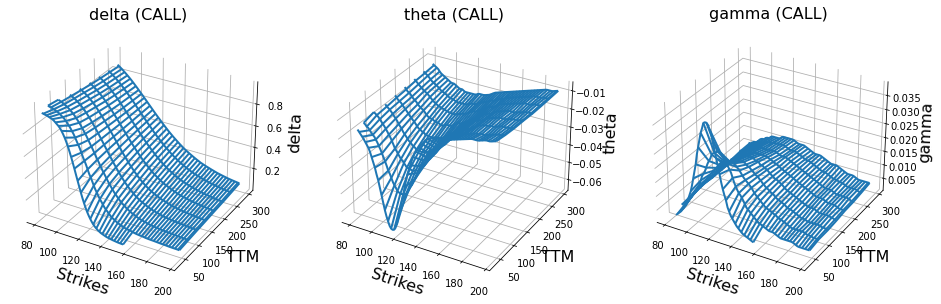

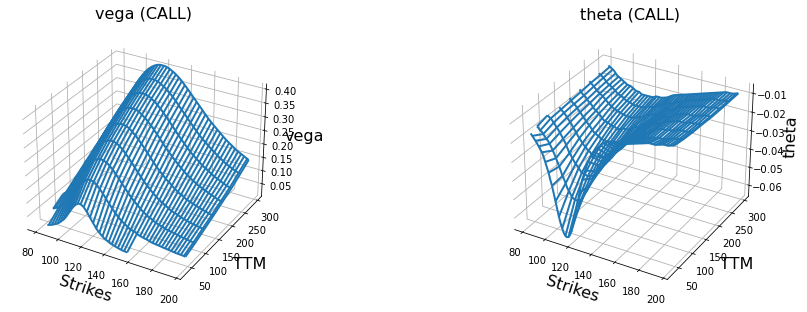

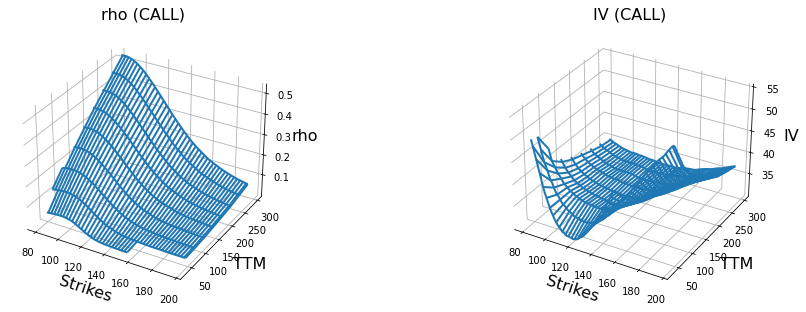

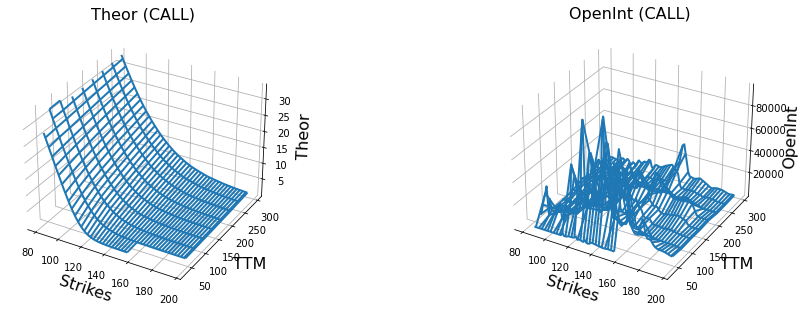

In [17]:
def prepararMalla(columna, df, leg=None):
    if leg:
        df = df.loc[df['Type']==leg].copy()
        
    df_ok = df.loc[:,['Strike','TTM',columna]]
    df_ok = df_ok.replace('NaN',np.nan).dropna()    
    x_q = len(df_ok['Strike'].unique())
    y_q = len(df_ok['TTM'].unique())
    x1 = np.linspace(df_ok['Strike'].min(), df_ok['Strike'].max(), x_q)
    y1 = np.linspace(df_ok['TTM'].min(), df_ok['TTM'].max(), y_q)
    X, Y = np.meshgrid(x1, y1)
    Z = interpolate.griddata((df_ok['Strike'], df_ok['TTM']), df_ok[columna], (X, Y))
    return X,Y,Z, df_ok

def grafCols(cols, leg=None, size=(16,5)):
    fig = plt.figure(figsize=size)
    ax = [fig.add_subplot(1, len(cols), i+1, projection='3d') for i in range(len(cols))]
    for i in range(len(cols)):
        col = cols[i]
        df_greeks = df_ok.copy()
        X,Y,Z,df = prepararMalla(col, df_greeks, leg=leg)    
        ax[i].plot_wireframe(X, Y, Z, color='tab:blue', lw=2)     
        ax[i].set_title(f'{col} ({leg})', fontsize=16, color='k')
        ax[i].set_xlabel('Strikes', fontsize=16, color='k')
        ax[i].set_ylabel('TTM', fontsize=16, color='k')
        ax[i].set_zlabel(col, fontsize=16, color='k')
        ax[i].w_xaxis.set_pane_color((0,0,0,0))
        ax[i].w_yaxis.set_pane_color((0,0,0,0))
        ax[i].w_zaxis.set_pane_color((0,0,0,0))

ticker = 'AAPL'
k_min = 80
k_max=200
ttm_min=25
ttm_max=365

%matplotlib inline

data = optionsDF(options(ticker))
df_ok = data.loc[(data['Strike'] > k_min) & (data['Strike'] < k_max)]
df_ok = df_ok.loc[(df_ok['TTM'] > ttm_min) & (df_ok['TTM'] < ttm_max)]   


grafCols(['delta','theta','gamma'], 'CALL')
grafCols(['vega','theta'], 'CALL')
grafCols(['rho','IV'], 'CALL')
grafCols(['Theor','OpenInt'], 'CALL')
plt.show()

## Gráfica 3D interactiva básica

<IPython.core.display.Javascript object>


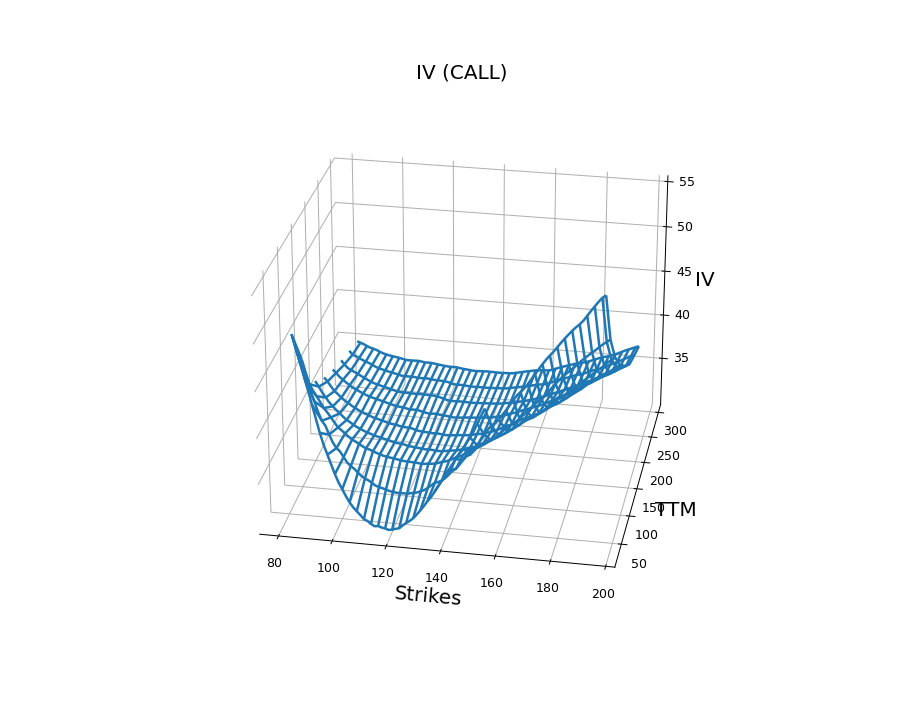

In [19]:
%matplotlib notebook

ticker = 'AAPL'
k_min = 80
k_max = 200
ttm_min = 25
ttm_max = 365

data = optionsDF(options(ticker))
df_ok = data.loc[(data['Strike'] > k_min) & (data['Strike'] < k_max)]
df_ok = df_ok.loc[(df_ok['TTM'] > ttm_min) & (df_ok['TTM'] < ttm_max)]   

grafCols(['IV'], 'CALL', size=(10,8))

## Bajamos Opciones del SP500

LIMIT RATE

In [21]:
with open('data/inicial/wiki_sp500.dat', 'rb') as file:
    loaded = pickle.load(file)

In [22]:
tickers= loaded.Symbol.to_list()
tickers[:10]

['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES']

In [23]:
n_threads = 2
subs = np.array_split(tickers, n_threads)

In [24]:
%%time

dfs = []
def worker(tickers):
    for ticker in tickers:
        for n in range(5):
            try:
                print(ticker, end=' ')
                df = optionsDF(options(ticker))
                dfs.append(df)
                break
            except:
                print(f'{"="*5} No se pudo descargar {ticker} Intento {n}{"="*5}\n')
                time.sleep(0.1)
    return df

threads = []
for i in range(n_threads):
    t = threading.Thread(target=worker, args=(subs[i],))
    threads.append(t)
    t.start()
    
for t in threads:
    t.join()
    
sp500_opciones = pd.concat(dfs)
sp500_opciones

MMM INTU ABT ISRG ABBV IVZ IPGP ABMD IQV IRM ACN JKHY J ATVI JBHT ADBE SJM JNJ AMD JCI AAP JPM AES JNPR AFL A KSU APD K KEY AKAM KEYS ALK KMB ALB ARE KIM KMI ALXN KLAC KHC KR ALGN LB ALLE LHX LNT ALL LH GOOGL LRCX GOOG LW LVS MO LEG LDOS AMZN LEN LLY AMCR AEE AAL LNC LIN AEP LYV AXP LKQ LMT AIG AMT AWK L AMP LOW ABC LUMN LYB AME AMGN MTB MRO APH MPC ADI ANSS MKTX ANTM MAR AON MMC AOS MLM APA MAS AIV AAPL MA AMAT MKC MXIM APTV MCD ADM ANET MCK MDT AJG MRK AIZ T MET ATO MTD ADSK MGM ADP MCHP AZO MU AVB MSFT AVY BKR MAA BLL MHK BAC TAP MDLZ BK BAX MNST MCO BDX MS BBY MOS BIO MSI BIIB MSCI BLK NDAQ NOV BA NTAP BKNG NFLX BWA NWL BXP NEM BSX NWSA BMY NWS NEE AVGO NLSN BR NKE CHRW NI COG NSC CDNS NTRS CPB NOC COF NLOK CAH NCLH KMX NRG NUE CCL NVDA CARR CTLT NVR CAT ORLY OXY CBOE ODFL CBRE OMC OKE CDW CE ORCL CNC OTIS PCAR CNP PKG CERN PH CF PAYX SCHW PAYC CHTR PYPL CVX PNR PBCT CMG PEP CB PKI CHD PRGO CI PFE CINF PM CTAS CSCO PSX C PNW PXD CFG CTXS PNC CLX POOL CME PPG CMS PPL KO PFG PG CTSH 

,symbol_opc,Strike,TTM,Type,Bid,Ask,Last,IV,OpenInt,Theor,delta,gamma,theta,vega,rho,ITM,symbol
0,MMM_112720C80,80.0,3,CALL,94.7,98.70,0.00,167.481,0,94.194,1,0,-0.012,0.000,0.01,True,MMM
1,MMM_112720C85,85.0,3,CALL,89.7,94.20,0.00,154.883,0,89.194,1,0,-0.012,0.000,0.011,True,MMM
2,MMM_112720C90,90.0,3,CALL,84.6,89.10,0.00,142.971,0,84.194,1,0,-0.012,0.000,0.012,True,MMM
3,MMM_112720C95,95.0,3,CALL,79.6,84.05,0.00,131.641,0,79.194,1,0,-0.012,0.000,0.012,True,MMM
4,MMM_112720C100,100.0,3,CALL,74.6,78.70,0.00,120.85,0,74.194,1,0,-0.012,0.000,0.013,True,MMM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,IFF_012023P165,165.0,787,PUT,59.6,64.50,0.00,29.035,0,65.276,-0.752,0.005,-0.015,0.410,-3.216,True,IFF
183,IFF_012023P170,170.0,787,PUT,63.5,68.50,0.00,29,0,69.805,-0.769,0.005,-0.015,0.384,-3.356,True,IFF
184,IFF_012023P175,175.0,787,PUT,69.1,72.00,68.24,29.014,3,74.407,-0.785,0.005,-0.015,0.359,-3.492,True,IFF
185,IFF_012023P180,180.0,787,PUT,73.7,76.50,72.27,29.031,1,79.056,-0.799,0.004,-0.014,0.335,-3.626,True,IFF


In [25]:
sp500_opciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332310 entries, 0 to 186
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   symbol_opc  332310 non-null  object 
 1   Strike      332310 non-null  float64
 2   TTM         332310 non-null  int64  
 3   Type        332310 non-null  object 
 4   Bid         332310 non-null  float64
 5   Ask         332310 non-null  float64
 6   Last        332310 non-null  float64
 7   IV          332310 non-null  object 
 8   OpenInt     332310 non-null  int64  
 9   Theor       332310 non-null  object 
 10  delta       332310 non-null  object 
 11  gamma       332310 non-null  object 
 12  theta       332310 non-null  object 
 13  vega        332310 non-null  float64
 14  rho         332310 non-null  object 
 15  ITM         332310 non-null  bool   
 16  symbol      332310 non-null  object 
dtypes: bool(1), float64(5), int64(2), object(9)
memory usage: 43.4+ MB


## Guardamos la data

In [27]:
with open('data/inicial/tda_opc_sp500.dat', 'wb') as file:
    pickle.dump(sp500_opciones, file)

In [28]:
with open('./data/inicial/tda_opc_sp500.dat', 'rb') as file:
    loaded = pickle.load(file)

pd.options.display.max_columns = 20
loaded

,symbol_opc,Strike,TTM,Type,Bid,Ask,Last,IV,OpenInt,Theor,delta,gamma,theta,vega,rho,ITM,symbol
0,MMM_112720C80,80.0,3,CALL,94.7,98.70,0.00,167.481,0,94.194,1,0,-0.012,0.000,0.01,True,MMM
1,MMM_112720C85,85.0,3,CALL,89.7,94.20,0.00,154.883,0,89.194,1,0,-0.012,0.000,0.011,True,MMM
2,MMM_112720C90,90.0,3,CALL,84.6,89.10,0.00,142.971,0,84.194,1,0,-0.012,0.000,0.012,True,MMM
3,MMM_112720C95,95.0,3,CALL,79.6,84.05,0.00,131.641,0,79.194,1,0,-0.012,0.000,0.012,True,MMM
4,MMM_112720C100,100.0,3,CALL,74.6,78.70,0.00,120.85,0,74.194,1,0,-0.012,0.000,0.013,True,MMM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,IFF_012023P165,165.0,787,PUT,59.6,64.50,0.00,29.035,0,65.276,-0.752,0.005,-0.015,0.410,-3.216,True,IFF
183,IFF_012023P170,170.0,787,PUT,63.5,68.50,0.00,29,0,69.805,-0.769,0.005,-0.015,0.384,-3.356,True,IFF
184,IFF_012023P175,175.0,787,PUT,69.1,72.00,68.24,29.014,3,74.407,-0.785,0.005,-0.015,0.359,-3.492,True,IFF
185,IFF_012023P180,180.0,787,PUT,73.7,76.50,72.27,29.031,1,79.056,-0.799,0.004,-0.014,0.335,-3.626,True,IFF


# IEX

In [32]:
def iex_intraday(symbol):
    url = f'https://cloud.iexapis.com/stable/stock/{symbol}/intraday-prices'
    params = {'chartIEXOnly':True, 'token':IEX_TOKEN }
    js = requests.get(url, params=params).json()
    df = pd.DataFrame(js)
    df.date = pd.to_datetime(df.date)
    df['symbol'] = symbol
    df['pctChange'] = df.average.pct_change()*100
    return df.dropna().round(3)

In [33]:
iex_intraday('AAPL')

,date,minute,label,high,low,open,close,average,volume,notional,numberOfTrades,symbol,pctChange
1,2020-11-24,09:31,09:31 AM,114.020,113.80,113.920,113.880,113.898,15786,1797992.480,148,AAPL,-0.021
2,2020-11-24,09:32,09:32 AM,113.890,113.73,113.875,113.730,113.811,12479,1420246.085,96,AAPL,-0.076
3,2020-11-24,09:33,09:33 AM,113.810,113.28,113.740,113.310,113.548,15622,1773844.585,119,AAPL,-0.231
4,2020-11-24,09:34,09:34 AM,113.285,112.77,113.285,112.930,112.998,38182,4314485.440,248,AAPL,-0.484
5,2020-11-24,09:35,09:35 AM,113.125,112.83,112.930,113.125,112.944,32618,3684004.545,139,AAPL,-0.048
...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,2020-11-24,15:55,3:55 PM,115.260,115.17,115.220,115.170,115.219,2619,301758.400,25,AAPL,-0.003
386,2020-11-24,15:56,3:56 PM,115.140,114.98,115.140,115.015,115.074,6760,777902.370,51,AAPL,-0.126
387,2020-11-24,15:57,3:57 PM,115.130,115.00,115.020,115.130,115.049,9747,1121378.580,71,AAPL,-0.022
388,2020-11-24,15:58,3:58 PM,115.140,114.97,115.140,115.005,115.018,3825,439945.075,36,AAPL,-0.027


## Descarga con hilos

In [34]:
n_threads = 50
subs = np.array_split(sp500_tickers, n_threads)

In [35]:
%%time

import time

dfs = []
def worker(tickers):
    for ticker in tickers:
        for i in range(5):
            try:
                print(ticker, end=' ')
                df = iex_intraday(ticker)
                dfs.append(df)
                break
            except:
                print(f'{"="*5} No se pudo descargar {ticker} Intento {i}{"="*5}\n')
                time.sleep(0.01)
            
    return df


threads = []
for i in range(n_threads):
    t = threading.Thread(target=worker, args=(subs[i],))
    threads.append(t)
    t.start()
    
for t in threads:
    t.join()
    
result = pd.concat(dfs)
result

MMM A GOOGL AWK AOST  BK BXP CAH CNC CI KO COO DHR DFS DTE EW ETSY FB FLIR FCX GL HSIC HST ILMN ISRG JCI KLAC LDOS LUMN MA MCHP MOS NWS NRG OTIS PKI PPL QRVO RF CRM SLG SYF TDY TDGUA VTR VNO  WFC WYNN ABT GOOG KMX APA BSXGPNNEE  ATO  APD CINFBAX  FLS EA HSYCNP  FAST DUK DRIUNP IVZ  AMP SBAC CTSH HWMEVRGLEN  MU  INCY VMCLYB  KHC CPRT PFGJPMRSGPRGO DISCA  XEL SNPS   VRSN PWR SNA TRVTFX GPS  MKCMSIWELL   NUE PCAR ABBV MO CCL AIV GS BMY BDX ADSK CTAS HESFMC  AKAM EMR CERNUAL  IPGP ESABCNLSN DVA   DRE FRT SLB PG WRBCL KR MTBMSFT   PFE QCOM SYY MXIMMSCILLY TERNVDA DISCK VRSK   HPQ GRMN AMZN  XRX GLW JNPRPKGAAPL  IR WSTTFC SO   ABMDRMD  CARR GWWAVGO  BBY F ADP HPE UNH CSCO ALK ETR CF DE IQV NKE FDX RE AME STX DD TMUS MRO PM CMCSA PGR VZ DISH LB HUM DGX MCD NVRPH  KSUXLNXTWTR WABLNC   NDAQ MAA HAL  ACN CTVA CTLT IT RHI BIOBR  INTCTXNWDC AMAT  AZO  FTNTAMCR  HLTUPS  LUV ALB EOG C SCHW NIDAL  IRM SEE FIS EXC AMGN CMA MPC TROW DXC PLD PSX VRTX RL LHX DG PAYX MCK HBAN ORLY CAT XYL TYL HBIWMTNOV   

,date,minute,label,high,low,open,close,average,volume,notional,numberOfTrades,symbol,pctChange
1,2020-11-24,09:31,09:31 AM,175.625,175.360,175.360,175.575,175.569,333.0,58464.525,6.0,MMM,0.252
2,2020-11-24,09:32,09:32 AM,175.740,175.480,175.650,175.740,175.609,163.0,28624.240,5.0,MMM,0.023
3,2020-11-24,09:33,09:33 AM,175.895,175.650,175.650,175.895,175.789,1009.0,177371.265,15.0,MMM,0.103
4,2020-11-24,09:34,09:34 AM,176.050,175.500,175.935,175.500,175.910,744.0,130876.710,12.0,MMM,0.069
5,2020-11-24,09:35,09:35 AM,176.050,175.600,175.600,175.950,175.925,426.0,74944.280,7.0,MMM,0.009
...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,2020-11-24,15:55,3:55 PM,345.185,344.900,345.185,344.960,345.017,1092.0,376758.745,26.0,INTU,0.091
386,2020-11-24,15:56,3:56 PM,344.890,344.760,344.850,344.760,344.811,1215.0,418945.340,20.0,INTU,-0.060
387,2020-11-24,15:57,3:57 PM,345.220,344.820,344.820,345.220,345.030,880.0,303626.810,24.0,INTU,0.064
388,2020-11-24,15:58,3:58 PM,345.170,344.825,345.150,344.825,344.980,1827.0,630278.020,35.0,INTU,-0.014


## Guardamos la Data

In [36]:
with open('data/inicial/iex_intra.dat', 'wb') as file:
    pickle.dump(result, file)

In [37]:
with open('data/inicial/iex_intra.dat', 'rb') as file:
    loaded = pickle.load(file)
    
loaded

,date,minute,label,high,low,open,close,average,volume,notional,numberOfTrades,symbol,pctChange
1,2020-11-24,09:31,09:31 AM,175.625,175.360,175.360,175.575,175.569,333.0,58464.525,6.0,MMM,0.252
2,2020-11-24,09:32,09:32 AM,175.740,175.480,175.650,175.740,175.609,163.0,28624.240,5.0,MMM,0.023
3,2020-11-24,09:33,09:33 AM,175.895,175.650,175.650,175.895,175.789,1009.0,177371.265,15.0,MMM,0.103
4,2020-11-24,09:34,09:34 AM,176.050,175.500,175.935,175.500,175.910,744.0,130876.710,12.0,MMM,0.069
5,2020-11-24,09:35,09:35 AM,176.050,175.600,175.600,175.950,175.925,426.0,74944.280,7.0,MMM,0.009
...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,2020-11-24,15:55,3:55 PM,345.185,344.900,345.185,344.960,345.017,1092.0,376758.745,26.0,INTU,0.091
386,2020-11-24,15:56,3:56 PM,344.890,344.760,344.850,344.760,344.811,1215.0,418945.340,20.0,INTU,-0.060
387,2020-11-24,15:57,3:57 PM,345.220,344.820,344.820,345.220,345.030,880.0,303626.810,24.0,INTU,0.064
388,2020-11-24,15:58,3:58 PM,345.170,344.825,345.150,344.825,344.980,1827.0,630278.020,35.0,INTU,-0.014


# Finviz

## Traemos los datos de la WEB

In [38]:
def scrapear(pags=range(1,3)):
    agents = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) '
    agents += 'Chrome/50.0.2661.75 Safari/537.36'
    header = {"User-Agent": agents, "X-Requested-With": "XMLHttpRequest"}
    vista_simple = '111'
    vista_full = '152&c='+','.join([str(s) for s in list(range(0,71))])

    df = pd.DataFrame()

    paginas = 1000
    with tqdm.tqdm(total=len(pags), file=sys.stdout) as pbar:
        for pagina in pags:
            pbar.update()

            r = str((pagina)*20 + 1)
            url = f'https://finviz.com/screener.ashx?v={vista_full}&r={r}'
            r = requests.get(url, headers=header)
            tablas = pd.read_html(r.text)

            for tabla in tablas:
                valor = tabla[0].values[0]
                if valor == 'No.':
                    data = tabla

                try:
                    if valor.find('Total: ') == 0:
                        paginas = int(valor[7:valor.find('#')-1])//20 +1
                except:
                    pass

            if pagina == paginas:
                break

            data.columns=data.loc[0]
            data = data.drop(0).drop('No.', axis=1).set_index('Ticker')
            df = pd.concat([df,data])

    return df

In [39]:
finviz = scrapear(pags=range(390))

 98%|██████████████████████████████████████████████████████████████████████████████▊ | 384/390 [03:18<00:03,  1.93it/s]


In [40]:
finviz

,Company,Sector,Industry,Country,Market Cap,P/E,Fwd P/E,PEG,P/S,P/B,...,Gap,Recom,Avg Volume,Rel Volume,Price,Change,Volume,Earnings,Target Price,IPO Date
Ticker,,,,,,,,,,,,,,,,,,,,,
A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,USA,34.65B,51.82,31.15,5.40,6.63,7.11,...,4.10%,2.20,1.29M,4.30,114.68,2.20%,5559092,Nov 23/a,106.40,11/18/1999
AA,Alcoa Corporation,Basic Materials,Aluminum,USA,3.89B,-,301.74,-,0.42,1.14,...,2.17%,2.60,5.31M,1.38,20.82,5.10%,7343515,Oct 14/a,14.43,10/18/2016
AAAU,Perth Mint Physical Gold ETF,Financial,Exchange Traded Fund,USA,-,-,-,-,-,-,...,-1.64%,-,647.38K,1.18,17.99,-1.59%,764202,-,-,8/15/2018
AACG,ATA Creativity Global,Consumer Defensive,Education & Training Services,China,38.72M,-,-,-,1.65,1.06,...,0.85%,-,75.04K,2.54,1.21,3.42%,190387,Nov 12/a,-,1/29/2008
AACQ,Artius Acquisition Inc.,Financial,Shell Companies,USA,717.98M,-,-,-,-,-,...,0.30%,-,321.06K,1.93,9.91,0.30%,618870,-,-,9/4/2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZUO,"Zuora, Inc.",Technology,Software - Infrastructure,USA,1.37B,-,-,-,4.71,8.08,...,0.69%,2.90,2.05M,0.44,11.72,0.77%,907210,Dec 03/a,13.58,4/12/2018
ZVO,Zovio Inc,Consumer Defensive,Education & Training Services,USA,127.29M,-,9.20,-,0.32,1.05,...,0.00%,1.00,415.26K,0.61,3.68,-2.65%,251613,Oct 28/a,-,4/15/2009
ZYME,Zymeworks Inc.,Healthcare,Biotechnology,Canada,1.93B,-,-,-,76.74,5.63,...,0.41%,1.50,448.05K,1.02,47.76,2.49%,457050,Nov 03/b,24.88,4/28/2017


## Guardamos la Data Inicial

In [41]:
with open('data/inicial/finviz.dat', 'wb') as file:
    pickle.dump(finviz, file)

In [42]:
with open('data/inicial/finviz.dat', 'rb') as file:
    loaded = pickle.load(file)
    
loaded

,Company,Sector,Industry,Country,Market Cap,P/E,Fwd P/E,PEG,P/S,P/B,...,Gap,Recom,Avg Volume,Rel Volume,Price,Change,Volume,Earnings,Target Price,IPO Date
Ticker,,,,,,,,,,,,,,,,,,,,,
A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,USA,34.65B,51.82,31.15,5.40,6.63,7.11,...,4.10%,2.20,1.29M,4.30,114.68,2.20%,5559092,Nov 23/a,106.40,11/18/1999
AA,Alcoa Corporation,Basic Materials,Aluminum,USA,3.89B,-,301.74,-,0.42,1.14,...,2.17%,2.60,5.31M,1.38,20.82,5.10%,7343515,Oct 14/a,14.43,10/18/2016
AAAU,Perth Mint Physical Gold ETF,Financial,Exchange Traded Fund,USA,-,-,-,-,-,-,...,-1.64%,-,647.38K,1.18,17.99,-1.59%,764202,-,-,8/15/2018
AACG,ATA Creativity Global,Consumer Defensive,Education & Training Services,China,38.72M,-,-,-,1.65,1.06,...,0.85%,-,75.04K,2.54,1.21,3.42%,190387,Nov 12/a,-,1/29/2008
AACQ,Artius Acquisition Inc.,Financial,Shell Companies,USA,717.98M,-,-,-,-,-,...,0.30%,-,321.06K,1.93,9.91,0.30%,618870,-,-,9/4/2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZUO,"Zuora, Inc.",Technology,Software - Infrastructure,USA,1.37B,-,-,-,4.71,8.08,...,0.69%,2.90,2.05M,0.44,11.72,0.77%,907210,Dec 03/a,13.58,4/12/2018
ZVO,Zovio Inc,Consumer Defensive,Education & Training Services,USA,127.29M,-,9.20,-,0.32,1.05,...,0.00%,1.00,415.26K,0.61,3.68,-2.65%,251613,Oct 28/a,-,4/15/2009
ZYME,Zymeworks Inc.,Healthcare,Biotechnology,Canada,1.93B,-,-,-,76.74,5.63,...,0.41%,1.50,448.05K,1.02,47.76,2.49%,457050,Nov 03/b,24.88,4/28/2017


## Arreglamos datos

### Eliminamos símbolos no numéricos

In [43]:
finviz.replace('-',np.nan, inplace=True)
finviz.replace({'%': ''}, regex=True, inplace=True)

### Arreglamos los numericos hibridos

In [44]:
def aNumerico(df, columnas):

    for columna in columnas:
        count_T, count_B, count_M, count_K = 0,0,0,0
        
        for idx, row in finviz.iterrows():
            try:
                trillones = (row[columna]).find('T') 
                billones = (row[columna]).find('B') 
                millones = (row[columna]).find('M')
                miles = (row[columna]).find('K')

                if  trillones > 0:
                    count_T += 1
                    row[columna] = int(round(float(row[columna][:trillones]),2) * 10**12)
                elif  billones > 0:
                    count_B += 1
                    row[columna] = int(round(float(row[columna][:billones]),2) * 10**9)
                elif  millones > 0:
                    count_M += 1
                    row[columna] = int(round(float(row[columna][:millones]),2) * 10**6)
                elif  miles > 0:
                    count_K += 1
                    row[columna] = int(round(float(row[columna][:miles]),2) * 10**3)
                else:
                    row[columna] = int(row[columna])
                    
            except:
                pass
            
        print(f'Columna: {columna}, T->{count_T}, B->{count_B}, M->{count_M}, K->{count_K}')

In [45]:
columnas = ['Market Cap', 'Avg Volume','Outstanding','Float',]

aNumerico(finviz, columnas)

Columna: Market Cap, T->0, B->2480, M->2932, K->0
Columna: Avg Volume, T->0, B->0, M->1711, K->5932
Columna: Outstanding, T->0, B->189, M->5225, K->0
Columna: Float, T->0, B->155, M->4683, K->0


### Pasamos a Flotante lo que sea flotante

In [46]:
finviz.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7643 entries, A to ZYXI
Data columns (total 69 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Company        7643 non-null   object
 1   Sector         7643 non-null   object
 2   Industry       7643 non-null   object
 3   Country        7643 non-null   object
 4   Market Cap     5412 non-null   object
 5   P/E            2555 non-null   object
 6   Fwd P/E        2906 non-null   object
 7   PEG            1676 non-null   object
 8   P/S            4802 non-null   object
 9   P/B            4837 non-null   object
 10  P/C            4393 non-null   object
 11  P/FCF          2522 non-null   object
 12  Dividend       4187 non-null   object
 13  Payout Ratio   2233 non-null   object
 14  EPS            5105 non-null   object
 15  EPS this Y     4684 non-null   object
 16  EPS next Y     4017 non-null   object
 17  EPS past 5Y    3945 non-null   object
 18  EPS next 5Y    3029 non-null   ob

In [49]:
def aFlotante(df, columnas):
    for columna in columnas:
        try:
            df[columna] = df[columna].astype(float)
        except:
            try:
                df[columna] = pd.to_numeric(df[columna])
            except:
                print (f'No se pudo trnasformar la columna {columna}')

In [50]:
columnas_no_float = ['Ticker', 'Company', 'Sector', 'Industry', 'Country', 'Market Cap',
                     'Outstanding','Float','Avg Volume','Volume', 'Earnings', 'IPO Date']

columnas_float = [col for col in list(finviz.columns) if col not in columnas_no_float]
aFlotante(finviz,columnas_float)

### Pasamos a Entero lo que es entero

In [51]:
def aEntero(df, columnas):
    for columna in columnas:
        df[columna] = pd.to_numeric(df[columna])

In [52]:
columnas_int = ['Market Cap', 'Outstanding','Float','Avg Volume','Volume']
aEntero(finviz, columnas_int)

### Pasamos a Fecha lo que se pueda pasar a fecha

In [53]:
finviz['IPO Date'] = pd.to_datetime(finviz['IPO Date'], format='%m/%d/%Y')

### Arreglamos nombres de columnas

In [54]:
columnas_nombres = [c.replace(' ','_') for c in list(finviz.columns)]
finviz.columns = columnas_nombres

In [55]:
columnas_nombres = [c.replace('/','_') for c in list(finviz.columns)]
finviz.columns = columnas_nombres

In [56]:
finviz.index.name = 'Symbol'

In [57]:
finviz.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7643 entries, A to ZYXI
Data columns (total 69 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Company        7643 non-null   object        
 1   Sector         7643 non-null   object        
 2   Industry       7643 non-null   object        
 3   Country        7643 non-null   object        
 4   Market_Cap     5412 non-null   float64       
 5   P_E            2555 non-null   float64       
 6   Fwd_P_E        2906 non-null   float64       
 7   PEG            1676 non-null   float64       
 8   P_S            4802 non-null   float64       
 9   P_B            4837 non-null   float64       
 10  P_C            4393 non-null   float64       
 11  P_FCF          2522 non-null   float64       
 12  Dividend       4187 non-null   float64       
 13  Payout_Ratio   2233 non-null   float64       
 14  EPS            5105 non-null   float64       
 15  EPS_this_Y     4684 non-nu

In [58]:
finviz

,Company,Sector,Industry,Country,Market_Cap,P_E,Fwd_P_E,PEG,P_S,P_B,...,Gap,Recom,Avg_Volume,Rel_Volume,Price,Change,Volume,Earnings,Target_Price,IPO_Date
Symbol,,,,,,,,,,,,,,,,,,,,,
A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,USA,3.465000e+10,51.82,31.15,5.4,6.63,7.11,...,4.10,2.2,1290000,4.30,114.68,2.20,5559092,Nov 23/a,106.40,1999-11-18
AA,Alcoa Corporation,Basic Materials,Aluminum,USA,3.890000e+09,NaN,301.74,NaN,0.42,1.14,...,2.17,2.6,5310000,1.38,20.82,5.10,7343515,Oct 14/a,14.43,2016-10-18
AAAU,Perth Mint Physical Gold ETF,Financial,Exchange Traded Fund,USA,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.64,NaN,647380,1.18,17.99,-1.59,764202,NaN,NaN,2018-08-15
AACG,ATA Creativity Global,Consumer Defensive,Education & Training Services,China,3.872000e+07,NaN,NaN,NaN,1.65,1.06,...,0.85,NaN,75040,2.54,1.21,3.42,190387,Nov 12/a,NaN,2008-01-29
AACQ,Artius Acquisition Inc.,Financial,Shell Companies,USA,7.179800e+08,NaN,NaN,NaN,NaN,NaN,...,0.30,NaN,321060,1.93,9.91,0.30,618870,NaN,NaN,2020-09-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZUO,"Zuora, Inc.",Technology,Software - Infrastructure,USA,1.370000e+09,NaN,NaN,NaN,4.71,8.08,...,0.69,2.9,2049999,0.44,11.72,0.77,907210,Dec 03/a,13.58,2018-04-12
ZVO,Zovio Inc,Consumer Defensive,Education & Training Services,USA,1.272900e+08,NaN,9.20,NaN,0.32,1.05,...,0.00,1.0,415260,0.61,3.68,-2.65,251613,Oct 28/a,NaN,2009-04-15
ZYME,Zymeworks Inc.,Healthcare,Biotechnology,Canada,1.930000e+09,NaN,NaN,NaN,76.74,5.63,...,0.41,1.5,448050,1.02,47.76,2.49,457050,Nov 03/b,24.88,2017-04-28


## Guardamos la Data Final

In [59]:
with open('data/final/finviz.dat', 'wb') as file:
    pickle.dump(finviz, file)

In [60]:
with open('data/final/finviz.dat', 'rb') as file:
    loaded = pickle.load(file)
    
loaded

,Company,Sector,Industry,Country,Market_Cap,P_E,Fwd_P_E,PEG,P_S,P_B,...,Gap,Recom,Avg_Volume,Rel_Volume,Price,Change,Volume,Earnings,Target_Price,IPO_Date
Symbol,,,,,,,,,,,,,,,,,,,,,
A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,USA,3.465000e+10,51.82,31.15,5.4,6.63,7.11,...,4.10,2.2,1290000,4.30,114.68,2.20,5559092,Nov 23/a,106.40,1999-11-18
AA,Alcoa Corporation,Basic Materials,Aluminum,USA,3.890000e+09,NaN,301.74,NaN,0.42,1.14,...,2.17,2.6,5310000,1.38,20.82,5.10,7343515,Oct 14/a,14.43,2016-10-18
AAAU,Perth Mint Physical Gold ETF,Financial,Exchange Traded Fund,USA,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.64,NaN,647380,1.18,17.99,-1.59,764202,NaN,NaN,2018-08-15
AACG,ATA Creativity Global,Consumer Defensive,Education & Training Services,China,3.872000e+07,NaN,NaN,NaN,1.65,1.06,...,0.85,NaN,75040,2.54,1.21,3.42,190387,Nov 12/a,NaN,2008-01-29
AACQ,Artius Acquisition Inc.,Financial,Shell Companies,USA,7.179800e+08,NaN,NaN,NaN,NaN,NaN,...,0.30,NaN,321060,1.93,9.91,0.30,618870,NaN,NaN,2020-09-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZUO,"Zuora, Inc.",Technology,Software - Infrastructure,USA,1.370000e+09,NaN,NaN,NaN,4.71,8.08,...,0.69,2.9,2049999,0.44,11.72,0.77,907210,Dec 03/a,13.58,2018-04-12
ZVO,Zovio Inc,Consumer Defensive,Education & Training Services,USA,1.272900e+08,NaN,9.20,NaN,0.32,1.05,...,0.00,1.0,415260,0.61,3.68,-2.65,251613,Oct 28/a,NaN,2009-04-15
ZYME,Zymeworks Inc.,Healthcare,Biotechnology,Canada,1.930000e+09,NaN,NaN,NaN,76.74,5.63,...,0.41,1.5,448050,1.02,47.76,2.49,457050,Nov 03/b,24.88,2017-04-28


# FMP

In [62]:
def getPanel(exchange):
    url = 'https://fmpcloud.io/api/v3/quotes/'+exchange
    p = {'apikey': FMP_KEY}
    r = requests.get(url, params = p)
    js = r.json()
    df = pd.DataFrame(js)
    df.set_index('symbol', inplace=True)
    return df

In [63]:
panel_etf = getPanel('nasdaq')
panel_etf.columns

Index(['name', 'price', 'changesPercentage', 'change', 'dayLow', 'dayHigh',
       'yearHigh', 'yearLow', 'marketCap', 'priceAvg50', 'priceAvg200',
       'volume', 'avgVolume', 'exchange', 'open', 'previousClose', 'eps', 'pe',
       'earningsAnnouncement', 'sharesOutstanding', 'timestamp'],
      dtype='object')

In [64]:
panel_etf

,name,price,changesPercentage,change,dayLow,dayHigh,yearHigh,yearLow,marketCap,priceAvg50,...,volume,avgVolume,exchange,open,previousClose,eps,pe,earningsAnnouncement,sharesOutstanding,timestamp
symbol,,,,,,,,,,,,,,,,,,,,,
MMDM,Modern Media Acquisition Corp.,1.320,0.76,0.0100,1.3100,1.3860,24.4500,0.5550,1.801906e+07,1.241971,...,381534.0,700734.0,NASDAQ,1.3300,1.3100,-1.482,NaN,2020-07-16T14:59:00.000+0000,13650800.0,1606263287
PRCP,"Perceptron, Inc.",6.970,0.14,0.0100,6.9400,6.9800,7.2900,2.3400,6.816346e+07,6.900000,...,101838.0,155158.0,NASDAQ,6.9600,6.9600,-0.515,NaN,2020-11-16T21:00:00.000+0000,9779550.0,1606263287
ANGI,ANGI Homeservices Inc.,11.540,-2.20,-0.2600,11.1950,11.8600,17.0500,4.1000,5.767657e+09,11.055834,...,3020668.0,3442407.0,NASDAQ,11.8300,11.8000,0.016,721.249940,2020-11-06T08:30:00.000+0000,499797008.0,1606263287
ARCC,Ares Capital Corporation,16.860,2.06,0.3400,16.7200,17.0000,19.3300,7.9000,7.125407e+09,14.658333,...,3280611.0,2041761.0,NASDAQ,16.7500,16.5200,0.727,23.191198,2020-10-27T07:00:01.000+0000,422622019.0,1606263287
FTXR,First Trust Nasdaq Transportation ETF,28.100,3.93,1.0616,27.4260,28.1000,28.1000,12.2000,NaN,24.931973,...,91912.0,563916.0,NASDAQ,27.4400,27.0384,NaN,NaN,None,NaN,1606263287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TBKCP,"Triumph Bancorp, Inc.",26.780,1.25,0.3300,26.4500,26.7800,26.9700,23.6000,NaN,26.234972,...,10531.0,14735.0,NASDAQ,26.4700,26.4500,NaN,NaN,2020-10-20T08:00:00.000+0000,NaN,1606263287
PSTVZ,Plus Therapeutics Inc WT,0.007,-10.26,-0.0008,0.0062,0.0082,0.0082,0.0062,NaN,NaN,...,283249.0,NaN,NASDAQ,0.0082,0.0078,NaN,NaN,None,NaN,1606263287
NUROW,"NeuroMetrix, Inc.",0.142,0.00,0.0000,0.1420,0.1500,0.1500,0.1420,NaN,NaN,...,450.0,NaN,NASDAQ,0.3530,0.1420,-5.694,NaN,2020-04-23T16:30:00.000+0000,NaN,1606263287


## Otros Paneles

In [65]:
paneles = ['etf','commodity','euronext','nyse','amex','nasdaq','tsx','index','mutual_fund']

## Bajamos todos

In [66]:
paneles = ['etf','commodity','euronext','nyse','amex','nasdaq','tsx','index','mutual_fund']

data_fmp = pd.DataFrame()
for panel in paneles:
    print(panel, end=', ')
    df = getPanel(panel)
    df['panel'] = panel
    data_fmp = pd.concat([data_fmp, df])

etf, commodity, euronext, nyse, amex, nasdaq, tsx, index, mutual_fund, 

In [67]:
data_fmp.groupby('panel').size()

panel
amex            284
commodity        29
etf             491
euronext       1255
index            62
mutual_fund    2518
nasdaq         4312
nyse           4600
tsx            1464
dtype: int64

In [68]:
data_fmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15015 entries, IAUF to GEQZX
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  14893 non-null  object 
 1   price                 14501 non-null  float64
 2   changesPercentage     15014 non-null  float64
 3   change                14485 non-null  float64
 4   dayLow                12010 non-null  float64
 5   dayHigh               12010 non-null  float64
 6   yearHigh              14487 non-null  float64
 7   yearLow               14487 non-null  float64
 8   marketCap             8633 non-null   object 
 9   priceAvg50            14085 non-null  float64
 10  priceAvg200           14088 non-null  float64
 11  volume                11978 non-null  float64
 12  avgVolume             14084 non-null  float64
 13  exchange              15015 non-null  object 
 14  open                  11944 non-null  float64
 15  previousClose        

## Guardamos la Data Inicial

In [69]:
with open('data/inicial/fmp.dat', 'wb') as file:
    pickle.dump(data_fmp, file)

In [70]:
with open('data/inicial/fmp.dat', 'rb') as file:
    loaded = pickle.load(file)
    
loaded

,name,price,changesPercentage,change,dayLow,dayHigh,yearHigh,yearLow,marketCap,priceAvg50,...,avgVolume,exchange,open,previousClose,eps,pe,earningsAnnouncement,sharesOutstanding,timestamp,panel
symbol,,,,,,,,,,,,,,,,,,,,,
IAUF,iShares Gold Strategy ETF,60.1610,-1.94,-1.189000,59.9610,60.5000,69.5400,50.000,NaN,63.361890,...,4681.0,ETF,60.5000,61.350000,NaN,NaN,None,NaN,1606263309,etf
XSHQ,Invesco S&P SmallCap Quality ETF,30.5332,2.01,0.600900,30.2200,30.5892,30.5892,18.700,NaN,27.672472,...,10889.0,ETF,30.5200,29.932300,NaN,NaN,None,NaN,1606263309,etf
OVLU,Invesco Russell 1000 Value Factor ETF,30.0883,-0.20,-0.060700,30.1000,30.1000,30.3180,28.620,NaN,30.088300,...,0.0,ETF,30.0800,30.149000,NaN,NaN,None,NaN,1606263309,etf
IEFN,iShares Evolved U.S. Financials ETF,24.7373,3.49,0.835000,24.6286,24.6286,26.9500,14.870,NaN,21.960945,...,613.0,ETF,24.5400,23.902300,NaN,NaN,None,NaN,1606263309,etf
PSMM,Invesco Moderately Conservative Multi-Asset Al...,14.3900,0.68,0.096500,14.3827,14.3827,14.3827,10.505,NaN,13.839778,...,2340.0,ETF,14.3827,14.293500,NaN,NaN,None,NaN,1606263309,etf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCTWX,Nicholas II Fund Class I,31.3400,0.51,0.160000,NaN,NaN,31.5700,18.770,NaN,30.036667,...,0.0,MUTUAL_FUND,NaN,31.180000,NaN,NaN,None,NaN,1606263319,mutual_fund
FHCCX,Fidelity Advisor Health Care Fund Class C,50.1000,-0.60,-0.299998,NaN,NaN,52.2100,32.670,NaN,50.231110,...,0.0,MUTUAL_FUND,NaN,50.399998,NaN,NaN,None,NaN,1606263319,mutual_fund
FSIMX,Salient Select Income Advisor,23.5700,0.13,0.030001,NaN,NaN,23.5700,23.570,NaN,23.570000,...,0.0,MUTUAL_FUND,NaN,23.539999,NaN,NaN,None,NaN,1606263319,mutual_fund


## Verificamos tipos de datos

In [71]:
data_fmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15015 entries, IAUF to GEQZX
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  14893 non-null  object 
 1   price                 14501 non-null  float64
 2   changesPercentage     15014 non-null  float64
 3   change                14485 non-null  float64
 4   dayLow                12010 non-null  float64
 5   dayHigh               12010 non-null  float64
 6   yearHigh              14487 non-null  float64
 7   yearLow               14487 non-null  float64
 8   marketCap             8633 non-null   object 
 9   priceAvg50            14085 non-null  float64
 10  priceAvg200           14088 non-null  float64
 11  volume                11978 non-null  float64
 12  avgVolume             14084 non-null  float64
 13  exchange              15015 non-null  object 
 14  open                  11944 non-null  float64
 15  previousClose        

## Transformamos a numérico

In [72]:
aFlotante(data_fmp, ['marketCap','eps','pe','earningsAnnouncement','sharesOutstanding'])

No se pudo trnasformar la columna earningsAnnouncement


## Transformamos fechas

In [73]:
data_fmp['timestamp'] = pd.to_datetime(data_fmp['timestamp'], unit='s')

In [74]:
data_fmp

,name,price,changesPercentage,change,dayLow,dayHigh,yearHigh,yearLow,marketCap,priceAvg50,...,avgVolume,exchange,open,previousClose,eps,pe,earningsAnnouncement,sharesOutstanding,timestamp,panel
symbol,,,,,,,,,,,,,,,,,,,,,
IAUF,iShares Gold Strategy ETF,60.1610,-1.94,-1.189000,59.9610,60.5000,69.5400,50.000,NaN,63.361890,...,4681.0,ETF,60.5000,61.350000,NaN,NaN,None,NaN,2020-11-25 00:15:09,etf
XSHQ,Invesco S&P SmallCap Quality ETF,30.5332,2.01,0.600900,30.2200,30.5892,30.5892,18.700,NaN,27.672472,...,10889.0,ETF,30.5200,29.932300,NaN,NaN,None,NaN,2020-11-25 00:15:09,etf
OVLU,Invesco Russell 1000 Value Factor ETF,30.0883,-0.20,-0.060700,30.1000,30.1000,30.3180,28.620,NaN,30.088300,...,0.0,ETF,30.0800,30.149000,NaN,NaN,None,NaN,2020-11-25 00:15:09,etf
IEFN,iShares Evolved U.S. Financials ETF,24.7373,3.49,0.835000,24.6286,24.6286,26.9500,14.870,NaN,21.960945,...,613.0,ETF,24.5400,23.902300,NaN,NaN,None,NaN,2020-11-25 00:15:09,etf
PSMM,Invesco Moderately Conservative Multi-Asset Al...,14.3900,0.68,0.096500,14.3827,14.3827,14.3827,10.505,NaN,13.839778,...,2340.0,ETF,14.3827,14.293500,NaN,NaN,None,NaN,2020-11-25 00:15:09,etf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCTWX,Nicholas II Fund Class I,31.3400,0.51,0.160000,NaN,NaN,31.5700,18.770,NaN,30.036667,...,0.0,MUTUAL_FUND,NaN,31.180000,NaN,NaN,None,NaN,2020-11-25 00:15:19,mutual_fund
FHCCX,Fidelity Advisor Health Care Fund Class C,50.1000,-0.60,-0.299998,NaN,NaN,52.2100,32.670,NaN,50.231110,...,0.0,MUTUAL_FUND,NaN,50.399998,NaN,NaN,None,NaN,2020-11-25 00:15:19,mutual_fund
FSIMX,Salient Select Income Advisor,23.5700,0.13,0.030001,NaN,NaN,23.5700,23.570,NaN,23.570000,...,0.0,MUTUAL_FUND,NaN,23.539999,NaN,NaN,None,NaN,2020-11-25 00:15:19,mutual_fund


## Guardamos la Data Final

In [75]:
with open('data/final/fmp.dat', 'wb') as file:
    pickle.dump(data_fmp, file)

In [76]:
with open('data/final/fmp.dat', 'rb') as file:
    loaded = pickle.load(file)
    
loaded

,name,price,changesPercentage,change,dayLow,dayHigh,yearHigh,yearLow,marketCap,priceAvg50,...,avgVolume,exchange,open,previousClose,eps,pe,earningsAnnouncement,sharesOutstanding,timestamp,panel
symbol,,,,,,,,,,,,,,,,,,,,,
IAUF,iShares Gold Strategy ETF,60.1610,-1.94,-1.189000,59.9610,60.5000,69.5400,50.000,NaN,63.361890,...,4681.0,ETF,60.5000,61.350000,NaN,NaN,None,NaN,2020-11-25 00:15:09,etf
XSHQ,Invesco S&P SmallCap Quality ETF,30.5332,2.01,0.600900,30.2200,30.5892,30.5892,18.700,NaN,27.672472,...,10889.0,ETF,30.5200,29.932300,NaN,NaN,None,NaN,2020-11-25 00:15:09,etf
OVLU,Invesco Russell 1000 Value Factor ETF,30.0883,-0.20,-0.060700,30.1000,30.1000,30.3180,28.620,NaN,30.088300,...,0.0,ETF,30.0800,30.149000,NaN,NaN,None,NaN,2020-11-25 00:15:09,etf
IEFN,iShares Evolved U.S. Financials ETF,24.7373,3.49,0.835000,24.6286,24.6286,26.9500,14.870,NaN,21.960945,...,613.0,ETF,24.5400,23.902300,NaN,NaN,None,NaN,2020-11-25 00:15:09,etf
PSMM,Invesco Moderately Conservative Multi-Asset Al...,14.3900,0.68,0.096500,14.3827,14.3827,14.3827,10.505,NaN,13.839778,...,2340.0,ETF,14.3827,14.293500,NaN,NaN,None,NaN,2020-11-25 00:15:09,etf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCTWX,Nicholas II Fund Class I,31.3400,0.51,0.160000,NaN,NaN,31.5700,18.770,NaN,30.036667,...,0.0,MUTUAL_FUND,NaN,31.180000,NaN,NaN,None,NaN,2020-11-25 00:15:19,mutual_fund
FHCCX,Fidelity Advisor Health Care Fund Class C,50.1000,-0.60,-0.299998,NaN,NaN,52.2100,32.670,NaN,50.231110,...,0.0,MUTUAL_FUND,NaN,50.399998,NaN,NaN,None,NaN,2020-11-25 00:15:19,mutual_fund
FSIMX,Salient Select Income Advisor,23.5700,0.13,0.030001,NaN,NaN,23.5700,23.570,NaN,23.570000,...,0.0,MUTUAL_FUND,NaN,23.539999,NaN,NaN,None,NaN,2020-11-25 00:15:19,mutual_fund


# Alpaca

## Traer Activos posibles

In [77]:
def assets(only_shorteables=False):    
    headers ={"APCA-API-KEY-ID" : ALPACA_KEY, "APCA-API-SECRET-KEY":ALPACA_SECRET}
    r = requests.get(url = "https://paper-api.alpaca.markets/v2/assets", 
                      headers = headers)

    js = r.json()
    df = pd.DataFrame(js)
    df = df.loc[df.status=='active'].drop(['status','class','easy_to_borrow',
                                          'tradable','marginable'], axis=1)
    
    if only_shorteables:
        df= df.loc[df.shortable==True]
        
    return df

In [78]:
activos = assets(only_shorteables=False)
tickers = activos.symbol.to_list()

In [79]:
activos

,id,exchange,symbol,name,shortable
0,e5b3b14c-9f37-48a1-a60c-7cb6182a9a9b,NYSE,KCAC,Kensington Capital Acquisition Corp.,False
1,b6d1aa75-5c9c-4353-a305-9e2caa1925ab,NASDAQ,MSFT,Microsoft Corporation Common Stock,True
2,81f61b55-adee-402e-87d4-7b49579e2338,NYSE,NCLH,Norwegian Cruise Line Holdings Ltd. Ordinary S...,False
3,5580841c-1413-4e23-a7f1-a7ad63a67cb2,NASDAQ,RLAY,"Relay Therapeutics, Inc. Common Stock",True
4,3a2004c6-789c-48eb-bdc7-1e0ae3fb8a27,NASDAQ,ATHE,Alterity Therapeutics Limited American Deposit...,False
...,...,...,...,...,...
10476,528e9c38-0e8c-4219-996e-25116168554e,ARCA,TAN,Invesco Solar ETF,False
10477,a62e1ba1-af52-411b-ab22-537c2cd2e67d,NASDAQ,TTD,"The Trade Desk, Inc. Class A Common Stock",True
10478,29d5331f-51de-45dc-a429-c0d3d62cb6a9,NYSE,TUP,Tupperware Brands Corporation,False
10479,bea0f181-afd8-4bd2-9486-85d3fc2f10d7,NYSE,UBER,"Uber Technologies, Inc.",True


## Guardamos tickers

In [80]:
with open('data/inicial/alpaca_tickers.dat', 'wb') as file:
    pickle.dump(activos, file)

In [81]:
with open('data/inicial/alpaca_tickers.dat', 'rb') as file:
    loaded = pickle.load(file)
    
loaded

,id,exchange,symbol,name,shortable
0,e5b3b14c-9f37-48a1-a60c-7cb6182a9a9b,NYSE,KCAC,Kensington Capital Acquisition Corp.,False
1,b6d1aa75-5c9c-4353-a305-9e2caa1925ab,NASDAQ,MSFT,Microsoft Corporation Common Stock,True
2,81f61b55-adee-402e-87d4-7b49579e2338,NYSE,NCLH,Norwegian Cruise Line Holdings Ltd. Ordinary S...,False
3,5580841c-1413-4e23-a7f1-a7ad63a67cb2,NASDAQ,RLAY,"Relay Therapeutics, Inc. Common Stock",True
4,3a2004c6-789c-48eb-bdc7-1e0ae3fb8a27,NASDAQ,ATHE,Alterity Therapeutics Limited American Deposit...,False
...,...,...,...,...,...
10476,528e9c38-0e8c-4219-996e-25116168554e,ARCA,TAN,Invesco Solar ETF,False
10477,a62e1ba1-af52-411b-ab22-537c2cd2e67d,NASDAQ,TTD,"The Trade Desk, Inc. Class A Common Stock",True
10478,29d5331f-51de-45dc-a429-c0d3d62cb6a9,NYSE,TUP,Tupperware Brands Corporation,False
10479,bea0f181-afd8-4bd2-9486-85d3fc2f10d7,NYSE,UBER,"Uber Technologies, Inc.",True


## Armamos listas de a 200 para Batch Requests

In [86]:
activos = assets(only_shorteables=True)
tickers = activos.symbol.to_list()

listas = []
for i in range(len(tickers)//200 + 1):
    listas.append(tickers[i*200 : (i+1)*200])


print('\n Ultima lista:\n',listas[len(listas)-1])
print('\n Cantidad de Ultima lista:',len(listas[len(listas)-1]))
print('\n Cantidad de listas de 200:',len(listas)-1)


 Ultima lista:
 ['UE', 'UNIT', 'UNM', 'UNTY', 'VOE', 'WHR', 'WTRE', 'WY', 'PIPP.U', 'FOSL', 'F', 'AAPL', 'KO', 'ORCL', 'CRSR', 'GDDY', 'NET', 'ROKU', 'SGEN', 'SVXY', 'TTD', 'UBER', 'UVXY']

 Cantidad de Ultima lista: 23

 Cantidad de listas de 200: 22


In [87]:
listas[0]

['MSFT',
 'RLAY',
 'ENG',
 'RDFN',
 'SM',
 'ADI',
 'BHFAN',
 'CX',
 'FEYE',
 'AAAU',
 'AAIC',
 'AAL',
 'AAME',
 'AAN',
 'AAOI',
 'FSLY',
 'AAON',
 'AMRC',
 'ARMK',
 'AAT',
 'AAP',
 'BHLB',
 'BWA',
 'ADUS',
 'AAWW',
 'AAXJ',
 'CLS',
 'AAXN',
 'CRTO',
 'CVE',
 'AB',
 'ABBV',
 'ABC',
 'ABCM',
 'DTP',
 'ABCB',
 'ABEO',
 'EQT',
 'ABEV',
 'ABG',
 'ABM',
 'EXFO',
 'FBP',
 'FBMS',
 'FDP',
 'ABMD',
 'ABR',
 'ABST',
 'FTI',
 'ABTX',
 'ACA',
 'ACAD',
 'GIS',
 'ACAM',
 'ACBI',
 'HEI',
 'ACC',
 'ACCD',
 'ACEL',
 'HPX',
 'ACCO',
 'ACEV',
 'ACGL',
 'IBTX',
 'IJK',
 'IVZ',
 'ACH',
 'ACHC',
 'LDL',
 'LOAN',
 'ACIA',
 'ACIW',
 'ACM',
 'ACLS',
 'ACMR',
 'ACND',
 'ACNB',
 'MTZ',
 'ACRE',
 'ACRS',
 'ACTG',
 'OVV',
 'ACWI',
 'ACWX',
 'ADBE',
 'ADC',
 'ADES',
 'ADM',
 'ADMA',
 'RELX',
 'RYN',
 'ADNT',
 'ADP',
 'ADS',
 'ADPT',
 'AEE',
 'TAC',
 'AEHR',
 'AEGN',
 'AEL',
 'THR',
 'AEM',
 'TOWN',
 'AENZ',
 'AEPPL',
 'AEP',
 'AEPPZ',
 'AER',
 'AES',
 'AEYE',
 'AFG',
 'AFI',
 'AFL',
 'AG',
 'AFIN',
 'AFMD',
 'AFYA'

In [88]:
def sublist_to_string(listas):
    for i in range(len(listas)):
        listas[i] = ','.join(listas[i])
    return listas

listas_str = sublist_to_string(listas)
listas_str[0]

'MSFT,RLAY,ENG,RDFN,SM,ADI,BHFAN,CX,FEYE,AAAU,AAIC,AAL,AAME,AAN,AAOI,FSLY,AAON,AMRC,ARMK,AAT,AAP,BHLB,BWA,ADUS,AAWW,AAXJ,CLS,AAXN,CRTO,CVE,AB,ABBV,ABC,ABCM,DTP,ABCB,ABEO,EQT,ABEV,ABG,ABM,EXFO,FBP,FBMS,FDP,ABMD,ABR,ABST,FTI,ABTX,ACA,ACAD,GIS,ACAM,ACBI,HEI,ACC,ACCD,ACEL,HPX,ACCO,ACEV,ACGL,IBTX,IJK,IVZ,ACH,ACHC,LDL,LOAN,ACIA,ACIW,ACM,ACLS,ACMR,ACND,ACNB,MTZ,ACRE,ACRS,ACTG,OVV,ACWI,ACWX,ADBE,ADC,ADES,ADM,ADMA,RELX,RYN,ADNT,ADP,ADS,ADPT,AEE,TAC,AEHR,AEGN,AEL,THR,AEM,TOWN,AENZ,AEPPL,AEP,AEPPZ,AER,AES,AEYE,AFG,AFI,AFL,AG,AFIN,AFMD,AFYA,AGCUU,AGFS,AGG,AGGY,AGIO,AGCO,AGEN,AGI,AGLE,AGNC,AGM,AGR,AGRX,AGNCN,AGNCP,AGQ,AGRO,AGS,AGTC,AGYS,AHC,AHH,AIN,AINV,AIRG,AIRR,AIV,AIZ,AJAX.U,AJRD,AJX,AKBA,AKR,AL,AGX,AGO,AIG,AIMC,AINC,AIR,AIRT,AIT,AIZP,AJG,AKAM,AKRO,AKTX,AKUS,ALB,ALDX,ALEC,ALGM,ALIM,ALCO,ALE,ALEX,ALG,ALGT,ALK,ALL,ALLK,ALNY,ALSK,ALTG,ALXN,AMAL,AMBA,ALTR,AMEH,AMG,AMH,AMHC,AMJ,AMKR,AMN,ALKS,ALLE,ALLY,ALRM,ALRS,ALSN,ALTA,ALUS'

## Traer historicos con Batch Request

In [89]:
def getHistory(symbol, start, end, timeframe='1D'):    
    start = dt.datetime.strftime(start, format='%Y-%m-%dT%T-04:00')
    end = dt.datetime.strftime(end, format='%Y-%m-%dT%T-04:00')

    headers ={"APCA-API-KEY-ID" : ALPACA_KEY, "APCA-API-SECRET-KEY":ALPACA_SECRET}
    params =  {'symbols' : symbol, 'start':start, 'end':end}
    endpoint = "https://data.alpaca.markets/v1/bars/"+timeframe
    r = requests.get(url = endpoint, headers =headers, params=params)
    js = r.json()
    
    tickers = symbol.split(",")
    for ticker in tickers:
        for i in range(len(js[ticker])):
            js[ticker][i]['ticker']=ticker
    return js

In [90]:
end =  dt.date.today() + dt.timedelta(days=1)
start = end - dt.timedelta(days=10)
getHistory('AAPL,FB', start, end, timeframe='5Min')

{'AAPL': [{'t': 1605528000,
   'o': 119.14,
   'h': 119.25,
   'l': 119.14,
   'c': 119.25,
   'v': 595,
   'ticker': 'AAPL'},
  {'t': 1605528600,
   'o': 118.85,
   'h': 118.85,
   'l': 118.85,
   'c': 118.85,
   'v': 100,
   'ticker': 'AAPL'},
  {'t': 1605528900,
   'o': 118.78,
   'h': 118.78,
   'l': 118.78,
   'c': 118.78,
   'v': 100,
   'ticker': 'AAPL'},
  {'t': 1605529200,
   'o': 118.56,
   'h': 118.56,
   'l': 118.47,
   'c': 118.5,
   'v': 400,
   'ticker': 'AAPL'},
  {'t': 1605530100,
   'o': 118.79,
   'h': 118.8,
   'l': 118.79,
   'c': 118.8,
   'v': 200,
   'ticker': 'AAPL'},
  {'t': 1605530400,
   'o': 118.83,
   'h': 118.83,
   'l': 118.83,
   'c': 118.83,
   'v': 100,
   'ticker': 'AAPL'},
  {'t': 1605531600,
   'o': 118.92,
   'h': 118.92,
   'l': 118.92,
   'c': 118.92,
   'v': 105,
   'ticker': 'AAPL'},
  {'t': 1605531900,
   'o': 119.08,
   'h': 119.08,
   'l': 119.04,
   'c': 119.04,
   'v': 325,
   'ticker': 'AAPL'},
  {'t': 1605532200,
   'o': 118.82,
   'h':

## Bajamos Historicos de todos los activos

In [91]:
%%time
dfs = []
with tqdm.tqdm(total=len(listas_str), file=sys.stdout) as pbar:
    for i in range(len(listas_str)):
        pbar.update()
        end =  dt.date.today() + dt.timedelta(days=1)
        start = end - dt.timedelta(days=7)
        data_js = getHistory(listas_str[i], start, end, timeframe='5Min')
        data_js_stack = ([dicc for activo in data_js.values() for dicc in activo])    
        df = pd.DataFrame(data_js_stack) 
        df.t = pd.to_datetime(df.t, unit='s')
        df.columns = ['Date','Open','High','Low','Close','Volume','Ticker']
        df = df.loc[df.Close!=0]
        df['pctChange'] = np.where(df.Ticker==df.Ticker.shift(),df.Close.pct_change().round(4)*100,np.nan)
        df.dropna(inplace=True)
        df.set_index('Date', inplace=True)
        dfs.append(df)

alpaca_5min = pd.concat(dfs)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [01:13<00:00,  3.20s/it]
Wall time: 1min 13s


In [92]:
alpaca_5min

,Open,High,Low,Close,Volume,Ticker,pctChange
Date,,,,,,,
2020-11-18 14:30:00,18.710,18.71,18.710,18.71,600,AAAU,0.43
2020-11-18 14:35:00,18.710,18.71,18.710,18.71,2975,AAAU,0.00
2020-11-18 15:00:00,18.700,18.70,18.700,18.70,100,AAAU,-0.05
2020-11-18 15:20:00,18.720,18.72,18.720,18.72,900,AAAU,0.11
2020-11-18 15:25:00,18.740,18.76,18.740,18.76,2500,AAAU,0.21
...,...,...,...,...,...,...,...
2020-11-24 20:35:00,29.225,29.24,29.210,29.21,11933,WY,-0.07
2020-11-24 20:40:00,29.220,29.22,29.190,29.20,9769,WY,-0.03
2020-11-24 20:45:00,29.190,29.22,29.190,29.21,11971,WY,0.03


## Guardamos la Data Inicial

In [93]:
with open('data/inicial/alpaca_5min.dat', 'wb') as file:
    pickle.dump(alpaca_5min, file)

In [94]:
with open('data/inicial/alpaca_5min.dat', 'rb') as file:
    loaded = pickle.load(file)
    
loaded

,Open,High,Low,Close,Volume,Ticker,pctChange
Date,,,,,,,
2020-11-18 14:30:00,18.710,18.71,18.710,18.71,600,AAAU,0.43
2020-11-18 14:35:00,18.710,18.71,18.710,18.71,2975,AAAU,0.00
2020-11-18 15:00:00,18.700,18.70,18.700,18.70,100,AAAU,-0.05
2020-11-18 15:20:00,18.720,18.72,18.720,18.72,900,AAAU,0.11
2020-11-18 15:25:00,18.740,18.76,18.740,18.76,2500,AAAU,0.21
...,...,...,...,...,...,...,...
2020-11-24 20:35:00,29.225,29.24,29.210,29.21,11933,WY,-0.07
2020-11-24 20:40:00,29.220,29.22,29.190,29.20,9769,WY,-0.03
2020-11-24 20:45:00,29.190,29.22,29.190,29.21,11971,WY,0.03


In [96]:
%matplotlib inline

<IPython.core.display.Javascript object>


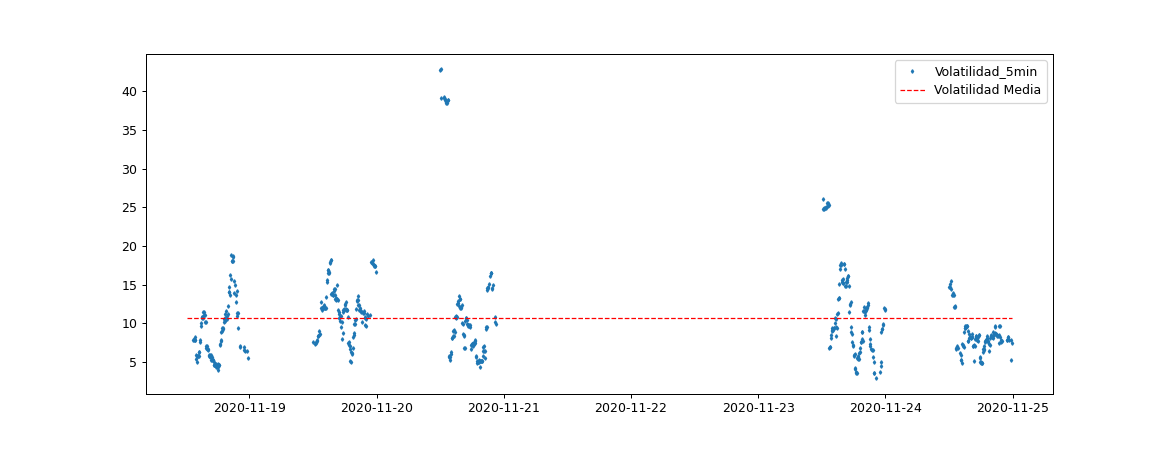

In [95]:
saltos_vol = loaded.loc[loaded.Ticker=='SPY'].pctChange.rolling(12).std() * (12*6.5*250)**0.5
vol_media = saltos_vol.mean()

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(13,5))

ax.plot(saltos_vol, lw=0, markersize=2, marker='d', label='Volatilidad_5min')
ax.plot(saltos_vol.index, [vol_media]*len(saltos_vol), '--r', lw=1, label='Volatilidad Media')
ax.legend()

# Tradier

https://developer.tradier.com/

## Prices

In [97]:
def getPrices(symbols):
    simbolos_sep_comas = ','.join(symbols)
    response = requests.get('https://sandbox.tradier.com/v1/markets/quotes',
    params={'symbols': {simbolos_sep_comas}, 'greeks': 'true'},
    headers={'Authorization': f'Bearer {TRADIER}', 'Accept': 'application/json'})

    js = response.json()['quotes']['quote']
    df = pd.DataFrame(js)
    return df

In [98]:
getPrices(['AAPL','MSFT'])

,symbol,description,exch,type,last,change,volume,open,high,low,...,prevclose,week_52_high,week_52_low,bidsize,bidexch,bid_date,asksize,askexch,ask_date,root_symbols
0,AAPL,Apple Inc,Q,stock,115.17,1.32,113706876,113.91,115.85,112.59,...,113.85,137.98,53.1525,2,K,1606263283000,1,P,1606263292000,AAPL
1,MSFT,Microsoft Corp,Q,stock,213.86,3.75,33951259,209.59,214.25,208.86,...,210.11,232.86,132.5200,1,K,1606263277000,1,P,1606263277000,MSFT


## Option Chain

In [99]:
def getOptionChain(symbol, exp):
    simbolos_sep_comas = ','.join(symbol)
    response = requests.get('https://sandbox.tradier.com/v1/markets/options/chains',
    params={'symbol': symbol, 'expiration': exp, 'greeks': 'true'},
    headers={'Authorization': f'Bearer {TRADIER}', 'Accept': 'application/json'})

    js = response.json()['options']['option']
    df = pd.DataFrame(js)
    return df

In [101]:
pd.options.display.max_columns = 8
data_tr = getOptionChain('SPY','2023-01-20')
data_tr

,symbol,description,exch,type,...,expiration_date,expiration_type,option_type,root_symbol
0,SPY230120P00165000,SPY Jan 20 2023 $165.00 Put,Z,option,...,2023-01-20,standard,put,SPY
1,SPY230120C00165000,SPY Jan 20 2023 $165.00 Call,Z,option,...,2023-01-20,standard,call,SPY
2,SPY230120P00170000,SPY Jan 20 2023 $170.00 Put,Z,option,...,2023-01-20,standard,put,SPY
3,SPY230120C00170000,SPY Jan 20 2023 $170.00 Call,Z,option,...,2023-01-20,standard,call,SPY
4,SPY230120P00175000,SPY Jan 20 2023 $175.00 Put,Z,option,...,2023-01-20,standard,put,SPY
...,...,...,...,...,...,...,...,...,...
147,SPY230120C00530000,SPY Jan 20 2023 $530.00 Call,Z,option,...,2023-01-20,standard,call,SPY
148,SPY230120P00535000,SPY Jan 20 2023 $535.00 Put,Z,option,...,2023-01-20,standard,put,SPY
149,SPY230120C00535000,SPY Jan 20 2023 $535.00 Call,Z,option,...,2023-01-20,standard,call,SPY
150,SPY230120P00540000,SPY Jan 20 2023 $540.00 Put,Z,option,...,2023-01-20,standard,put,SPY


In [104]:
data_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symbol             152 non-null    object 
 1   description        152 non-null    object 
 2   exch               152 non-null    object 
 3   type               152 non-null    object 
 4   last               132 non-null    float64
 5   change             132 non-null    float64
 6   volume             152 non-null    int64  
 7   open               50 non-null     float64
 8   high               50 non-null     float64
 9   low                50 non-null     float64
 10  close              50 non-null     float64
 11  bid                152 non-null    float64
 12  ask                152 non-null    float64
 13  underlying         152 non-null    object 
 14  strike             152 non-null    float64
 15  greeks             152 non-null    object 
 16  change_percentage  132 non

In [105]:
data_tr.loc[:,'greeks']

0      {'delta': -0.009549, 'gamma': 0.000604932, 'th...
1      {'delta': 0.990451, 'gamma': 0.000604932, 'the...
2      {'delta': -0.015509, 'gamma': 0.000706579, 'th...
3      {'delta': 0.984491, 'gamma': 0.000706579, 'the...
4      {'delta': -0.021284, 'gamma': 0.000808348, 'th...
                             ...                        
147    {'delta': 0.0665478, 'gamma': 0.00143434, 'the...
148    {'delta': -0.9381059, 'gamma': 0.00135481, 'th...
149    {'delta': 0.0618941, 'gamma': 0.00135481, 'the...
150    {'delta': -0.9427089, 'gamma': 0.00127612, 'th...
151    {'delta': 0.0572911, 'gamma': 0.00127612, 'the...
Name: greeks, Length: 152, dtype: object

## Expirations

In [106]:
def getOptionExp(symbol):
    simbolos_sep_comas = ','.join(symbol)
    response = requests.get('https://sandbox.tradier.com/v1/markets/options/expirations',
    params={'symbol': symbol, 'includeAllRoots': 'true', 'strikes': 'true'},
    headers={'Authorization': f'Bearer {TRADIER}', 'Accept': 'application/json'})

    js = response.json()['expirations']['expiration']
    
    dates = [v['date'] for v in js]
    strikes = [v['strikes']['strike'] for v in js]
    df = pd.DataFrame(strikes, index=dates)

    return df

In [107]:
exp = getOptionExp('SPY')
exp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34 entries, 2020-11-25 to 2023-01-20
Columns: 275 entries, 0 to 274
dtypes: float64(275)
memory usage: 73.3+ KB


In [108]:
exp.loc['2023-01-20'].dropna()

0     165.0
1     170.0
2     175.0
3     180.0
4     185.0
      ...  
71    520.0
72    525.0
73    530.0
74    535.0
75    540.0
Name: 2023-01-20, Length: 76, dtype: float64

## Historico de Opciones

In [109]:
def getHist(symbol, desde, hasta):
    response = requests.get('https://sandbox.tradier.com/v1/markets/history',
        params={'symbol': symbol, 'interval': 'daily', 'start': desde, 'end': hasta},
        headers={'Authorization': f'Bearer {TRADIER}', 'Accept': 'application/json'}
    )
    js = response.json()['history']['day']
    df = pd.DataFrame(js)
    return df

In [110]:
data = getHist('SPY201120P00125000', desde='2019-05-04', hasta='2020-12-04')
data

,date,open,high,low,close,volume
0,2020-03-19,5.71,5.71,5.71,5.71,1
1,2020-03-20,4.44,4.82,3.80,4.82,13
2,2020-03-23,5.08,5.08,3.95,3.95,7
3,2020-03-24,2.20,2.20,2.20,2.20,5
4,2020-03-25,2.18,2.18,2.18,2.18,1
...,...,...,...,...,...,...
94,2020-10-28,0.01,0.03,0.01,0.03,16
95,2020-10-30,0.02,0.02,0.02,0.02,21
96,2020-11-02,0.01,0.01,0.01,0.01,100
97,2020-11-03,0.01,0.02,0.01,0.01,1480


In [ ]:
!

In [ ]:
vultr

digitalocean

aws

primary

